# Spectrum Analyzer

Please follow the instructions on the pdf.
Run and compile the following 2 cells - DO NOT EDIT THEM!

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio

In [2]:
def frame(y, frame_length=1024, hop_length=512): # FRAME FUNCTION, PROVIDED
    '''Slice a time series into overlapping frames.

    This implementation uses low-level stride manipulation to avoid
    redundant copies of the time series data.

    Parameters
    ----------
    y : np.ndarray [shape=(n,)]
        Time series to frame. Must be one-dimensional and contiguous
        in memory.

    frame_length : int > 0 [scalar]
        Length of the frame in samples

    hop_length : int > 0 [scalar]
        Number of samples to hop between frames

    Returns
    -------
    y_frames : np.ndarray [shape=(frame_length, N_FRAMES)]
        An array of frames sampled from `y`:
        `y_frames[i, j] == y[j * hop_length + i]`

    Raises
    ------
    ParameterError
        If `y` is not contiguous in memory, not an `np.ndarray`, or
        not one-dimensional.  See `np.ascontiguous()` for details.

        If `hop_length < 1`, frames cannot advance.

        If `len(y) < frame_length`.

    Examples
    --------
    Extract 2048-sample frames from `y` with a hop of 64 samples per frame

    >>> y, sr = librosa.load(librosa.util.example_audio_file())
    >>> librosa.util.frame(y, frame_length=2048, hop_length=64)
    array([[ -9.216e-06,   7.710e-06, ...,  -2.117e-06,  -4.362e-07],
           [  2.518e-06,  -6.294e-06, ...,  -1.775e-05,  -6.365e-06],
           ...,
           [ -7.429e-04,   5.173e-03, ...,   1.105e-05,  -5.074e-06],
           [  2.169e-03,   4.867e-03, ...,   3.666e-06,  -5.571e-06]], dtype=float32)

    '''

    if not isinstance(y, np.ndarray):
        raise ParameterError('Input must be of type numpy.ndarray, '
                             'given type(y)={}'.format(type(y)))

    if y.ndim != 1:
        raise ParameterError('Input must be one-dimensional, '
                             'given y.ndim={}'.format(y.ndim))

    if len(y) < frame_length:
        raise ParameterError('Buffer is too short (n={:d})'
                             ' for frame_length={:d}'.format(len(y), frame_length))

    if hop_length < 1:
        raise ParameterError('Invalid hop_length: {:d}'.format(hop_length))

    if not y.flags['C_CONTIGUOUS']:
        raise ParameterError('Input buffer must be contiguous.')

    # Compute the number of frames that will fit. The end may get truncated.
    n_frames = 1 + int((len(y) - frame_length) / hop_length)

    # Vertical stride is one sample
    # Horizontal stride is `hop_length` samples
    y_frames = np.lib.stride_tricks.as_strided(y, shape=(frame_length, n_frames),
                          strides=(y.itemsize, hop_length * y.itemsize))
    return y_frames

In [3]:
def buffer2(x, seg_len): # used for the rectangular window
    num_co = int(np.ceil(len(x)/seg_len))
    out = np.zeros([seg_len,num_co])
    i = 0
    for c in range(0,np.shape(out)[1]):
        for r in range(0,np.shape(out)[0]):           
            if i<len(x):
                out[r,c] += x[i]
                i += 1       
    return out

In [4]:
new = np.random.randn(44100)
out = buffer2(new, 1024)
print(out.shape)

(1024, 44)


# PART 1

-  Fill the skeleton functions below with the correct code
-  Generate a matrix that contains snapshots in time of a signal's the frequency content.


In [5]:
def spectrum(sig, fs, buf_length, win_type, pad_length=0):
    if (win_type == "rect"):
        frames = buffer2(sig, buf_length)
    else:
        hop_length1 = int(buf_length/2)
        # 1. Slice signal into overlapping buffer frames (a function to do this is provided)
        frames = frame(sig, frame_length=buf_length, hop_length=hop_length1)
    a = np.empty_like(frames) # new array
    final = np.zeros((int(frames.shape[0]/2) + 1, frames.shape[1])) # new array
    for j in range(frames.shape[1]): # loop through cols
        # 2. Apply a window to each frame:
        if (win_type == "rect"):
            a[:,j] = frames[:,j] * np.kaiser(buf_length,0)
        if (win_type == "hamming"):
            a[:,j] = frames[:,j] * np.hamming(buf_length)
        if (win_type == "hann"):
            a[:,j] = frames[:,j] * np.hanning(buf_length)
        if (win_type == "blackman"):
            a[:,j] = frames[:,j] * np.blackman(buf_length)
        # 3. Extract the frequency magnitude at each frame by doing the following:
        # a. fft and magnitude extraction, remove replicas
        frame_fft = np.abs(np.fft.rfft(a[:,j])) #rfft takes real values            
        # b. normalize
        frames_norm = frame_fft/np.max(np.abs(frame_fft))
        # c. transformation into dB scale
        y = 20* np.log10(frames_norm)
        # d. output the result in a matrix 
        final [:,j] = y
    # 4. Compute and return the appropriate axis ticks for plotting (y-axis = frequency, x-axis = time)
    f_vector = np.linspace(0, fs/2, final.shape[0])
    t_vector = np.linspace(0, len(sig)/fs, final.shape[1]) 

    return final, f_vector, t_vector

# PART 1.2

-  Load test signals (mono)

In [6]:
a2, fs = sf.read('AudioA2.wav')
Audio(a2,rate=fs)
win_type = "hann" # hann works best?
buf_length = 1024
y1, f_vector1, t_vector1 = spectrum(a2, fs, buf_length, win_type, pad_length=0)


#### Load a second test signal of your choice

##### (Don't forget to include it with you assignment)

In [7]:
a3, fs3 = sf.read('007mono.wav')
Audio(a3,rate=fs3)
win_type = "hann"
buf_length = 1024
y2, f_vector2, t_vector2 = spectrum(a3, fs3, buf_length, win_type, pad_length=0)


# PART 2

-  Use the matrices generated above to plot and display the two spectrograms using np.pcolormesh()
-  Remember to specify inside pcolor both axis so that the numbers represent time (x-axis) and frequency (y-axis).
-  Make sure the spectrogram only displays unaliased audio.

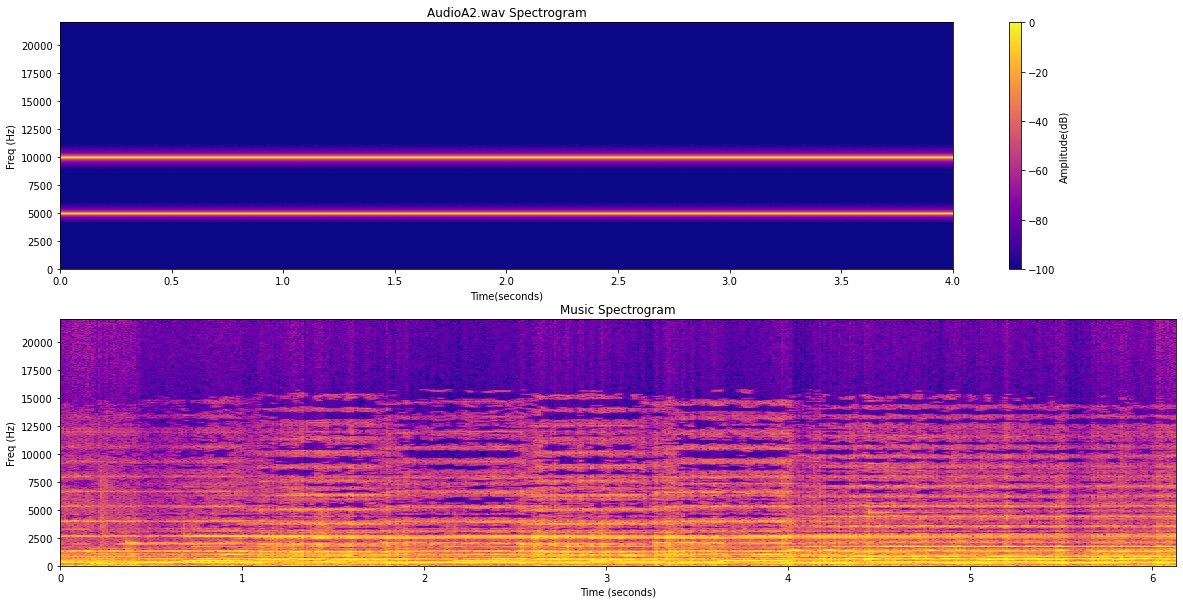

In [8]:
color = 'plasma'
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
c = plt.pcolormesh(t_vector1, f_vector1, y1, cmap = color, vmin=-100)
plt.colorbar(c, label="Amplitude(dB)")
plt.xlabel('Time(seconds)')
plt.ylabel('Freq (Hz)')
plt.title('AudioA2.wav Spectrogram') 

plt.subplot(2, 1, 2)
d = plt.pcolormesh(t_vector2, f_vector2, y2, cmap = color,vmin=-100)
plt.xlabel('Time (seconds)')
plt.ylabel('Freq (Hz)')
plt.title('Music Spectrogram') 

plt.show() 

# Extra Credit 